<h1> What Makes a Good Airbnb Listing? </h1>
<h2> Supervised Learning </h2>
<p> <em> Amsterdam, The Netherlands </em> </p>

<img src="am-2.jpg" width=409 height=512 />

<h2>Questions:</h2> <br>
1. Can we predict Airbnb listing price? <br>
2. Can we predict the rating of an Airbnb listing? <br>

<h2>Setup</h2>

<h3>Imports</h3>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import langid
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import preprocessing
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect.lang_detect_exception import LangDetectException
from langdetect import detect
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

<h3>Load Data</h3>

In [16]:
listings = pd.read_csv('listings.csv')
#sentfeatures = pd.read_csv('sentiment_features.csv')

##Replace NaN values with 0s and convert the price strings into floats, then drop outliers
listings.fillna({'neighborhood_overview':"NoOverview"}, inplace=True)
listings['neighbourhood_group_cleansed'] = listings['neighbourhood_cleansed']
listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)
listings = listings.drop(listings.index[listings['price'] >= 5500])

<h2>Visualize Data</h2>

In [17]:
sns.set_theme()
sns.set_palette("husl", 9) #crest

<h3>Amount of Listings for Each Neighborhood</h3>
<p>For Amsterdam, these are about 22 different neighborhoods. As seen in the graph below, the Airbnb listings seem to be normally distriubuted but skewed to the right.</p>

<a href=https://www.iamsterdam.com/en/about-amsterdam/amsterdam-neighbourhoods>Neighborhoods of Amsterdam</a>

No handles with labels found to put in legend.


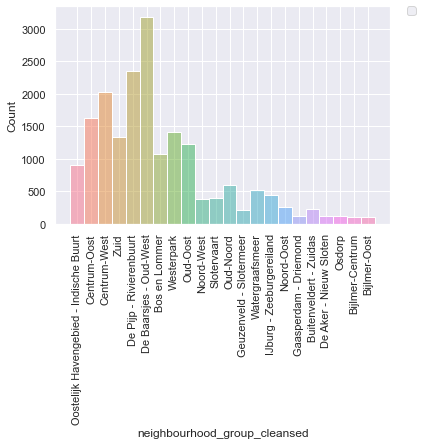

In [19]:
sns.histplot(data=listings, x="neighbourhood_group_cleansed", hue="neighbourhood_group_cleansed")
plt.xticks(rotation='vertical')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

<h3>Distribution of Listing Prices</h3>
<p>Prices appear to be between <strong>at most</strong> around 2000 USD for a majority of the listings, but there are a small number of more expensive listings as well.</p>

<AxesSubplot:xlabel='price', ylabel='Density'>

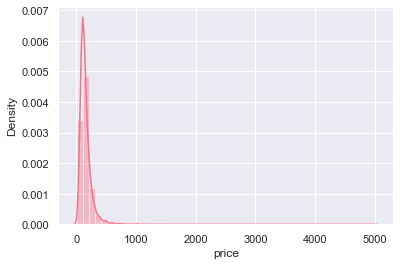

In [20]:
sns.distplot(listings['price'])

<h3>Price Distributions for Each Neighborhood Group</h3>
<p>A vast majority of the listings appear to be at most 1000 USD, with very few outliers. Centrum-Oost, Centrum-West, Zuid, and De Pijp - Rivierenbuurt, have the most count of more expensive listings.</p>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 [Text(0, 0, 'Oostelijk Havengebied - Indische Buurt'),
  Text(1, 0, 'Centrum-Oost'),
  Text(2, 0, 'Centrum-West'),
  Text(3, 0, 'Zuid'),
  Text(4, 0, 'De Pijp - Rivierenbuurt'),
  Text(5, 0, 'De Baarsjes - Oud-West'),
  Text(6, 0, 'Bos en Lommer'),
  Text(7, 0, 'Westerpark'),
  Text(8, 0, 'Oud-Oost'),
  Text(9, 0, 'Noord-West'),
  Text(10, 0, 'Slotervaart'),
  Text(11, 0, 'Oud-Noord'),
  Text(12, 0, 'Geuzenveld - Slotermeer'),
  Text(13, 0, 'Watergraafsmeer'),
  Text(14, 0, 'IJburg - Zeeburgereiland'),
  Text(15, 0, 'Noord-Oost'),
  Text(16, 0, 'Gaasperdam - Driemond'),
  Text(17, 0, 'Buitenveldert - Zuidas'),
  Text(18, 0, 'De Aker - Nieuw Sloten'),
  Text(19, 0, 'Osdorp'),
  Text(20, 0, 'Bijlmer-Centrum'),
  Text(21, 0, 'Bijlmer-Oost')])

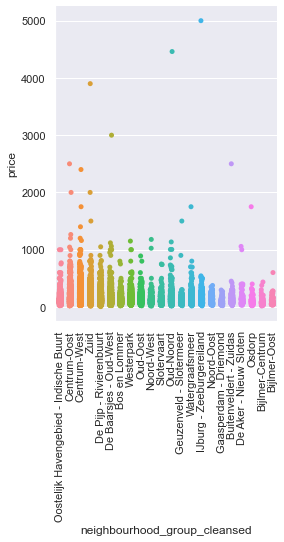

In [23]:
sns.catplot(data=listings, x="neighbourhood_group_cleansed", y="price")
plt.xticks(rotation='vertical')

<h3>Price Distributions for Room Type : Each Neighborhood Group</h3>
<p>There are 4 room types: Private rooms, Shared rooms, Entire homes/apartments, and Hotel Rooms. [Hotel rooms are the 4th set of bars, but the axis isn't labeling them for some reason]</p>

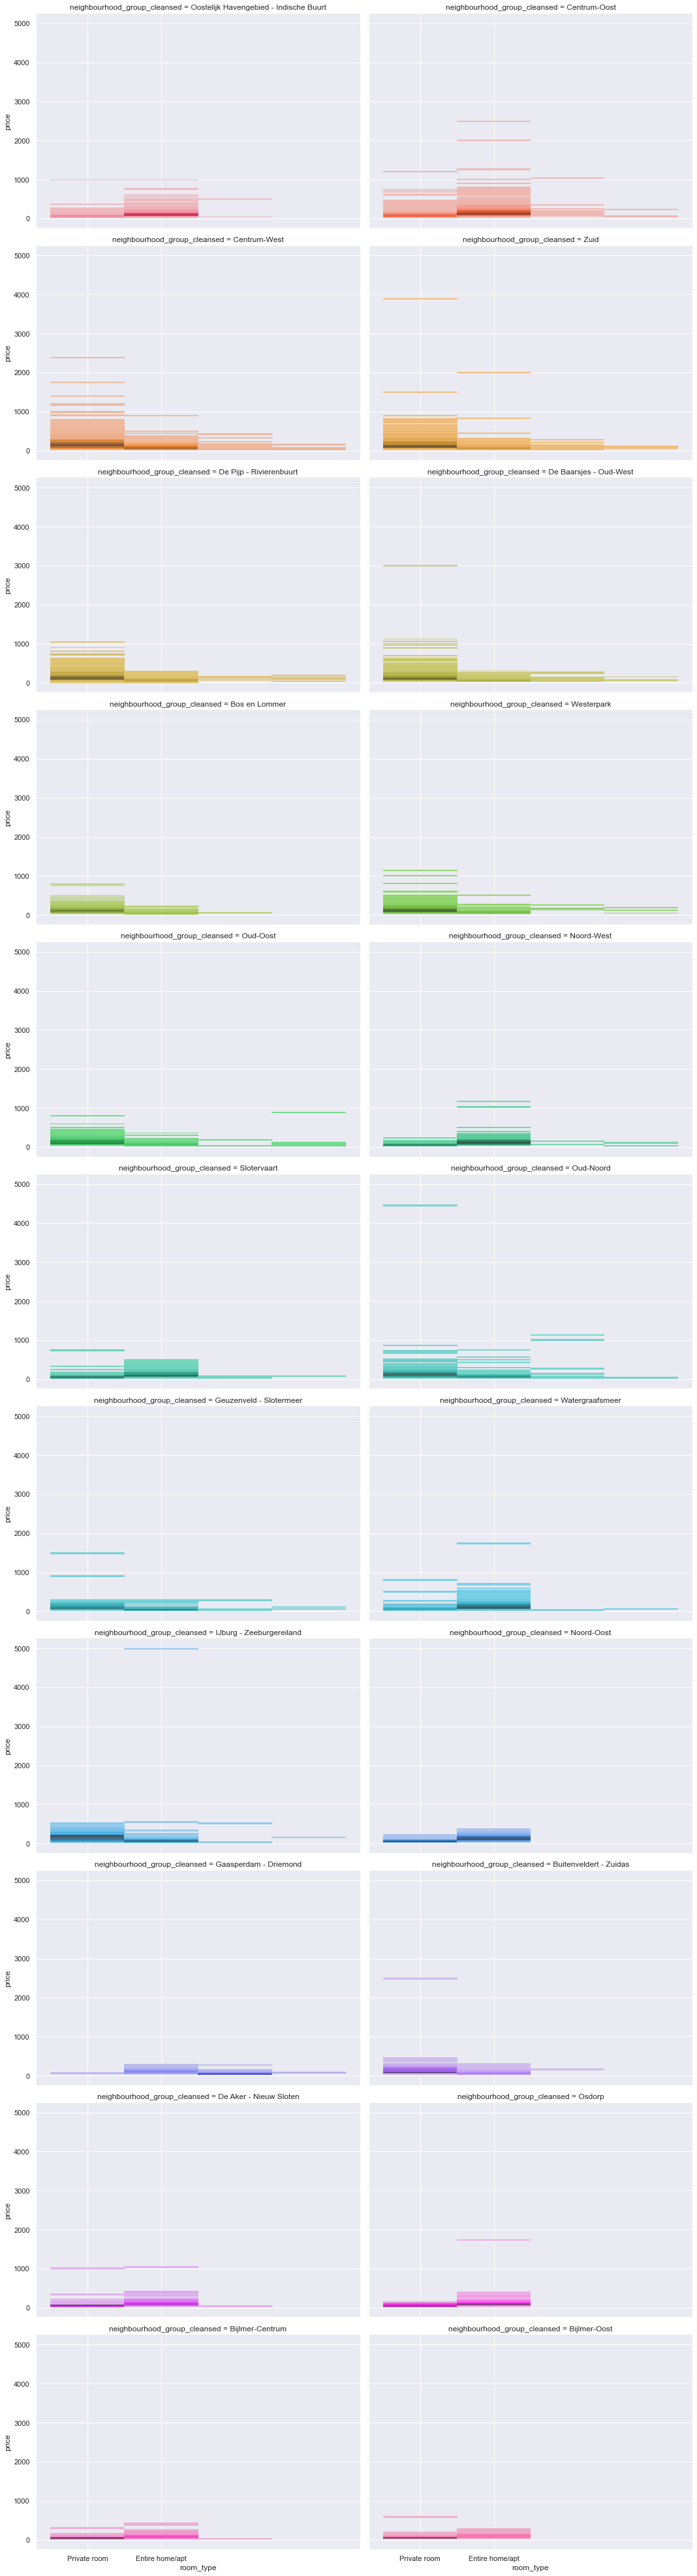

In [24]:
g = sns.FacetGrid(listings, col="neighbourhood_group_cleansed", col_wrap=2, height=5, 
                  aspect=1.5, hue="neighbourhood_group_cleansed")
g.map(sns.histplot, "room_type", "price")

<h3>Price Distributions for Accommodation Size : Each Neighborhood Group</h3>
<p>Listing price goes up as the accommodation size goes up.</p>

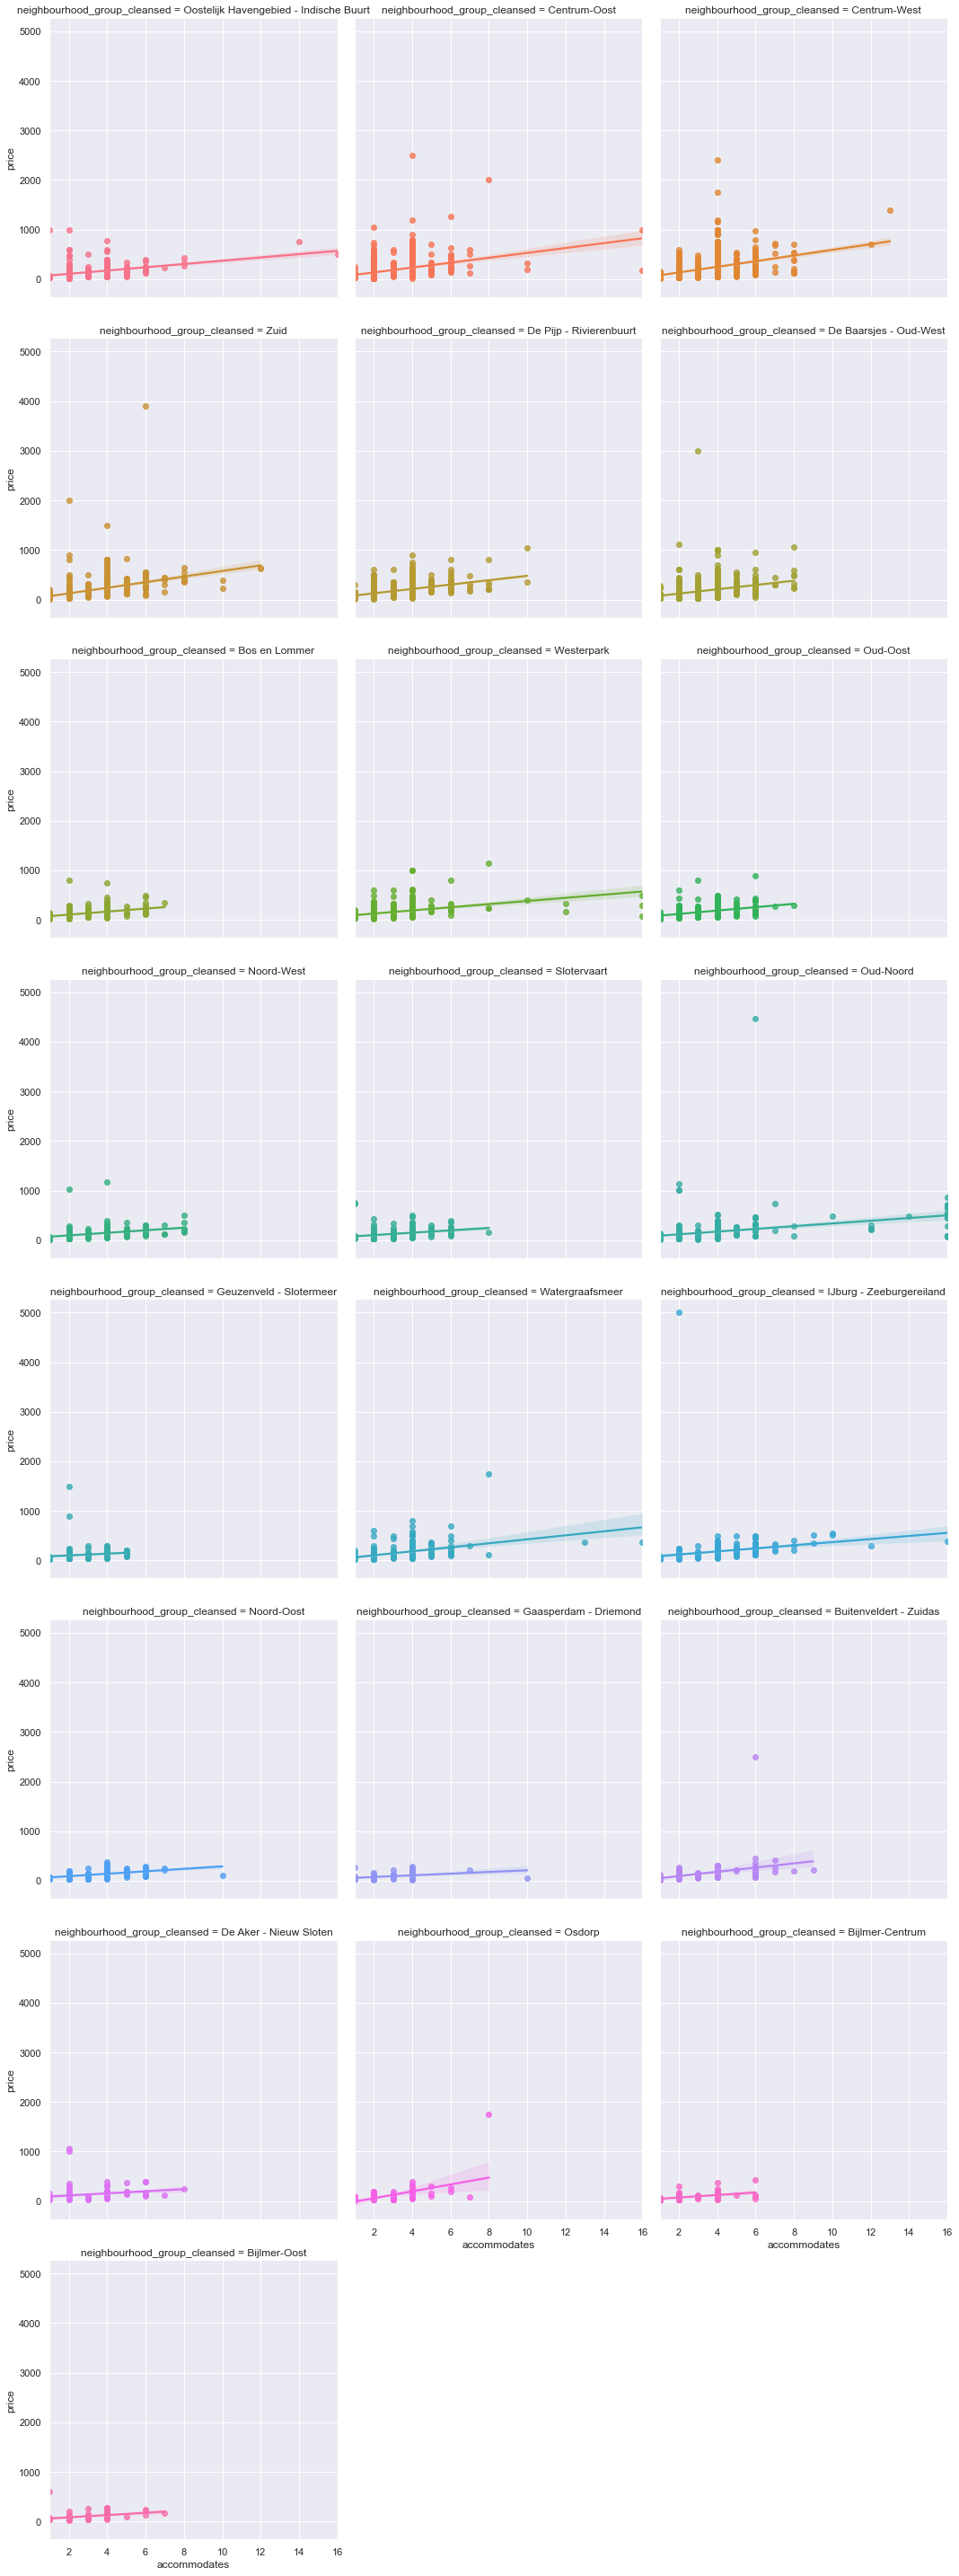

In [25]:
g = sns.FacetGrid(listings, col="neighbourhood_group_cleansed", col_wrap=3, height=5, hue="neighbourhood_group_cleansed")
g.map(sns.regplot, "accommodates", "price")

<h2> Clean & Preprocess Data </h2>

<p>Most ML algorithms cannot handle categorical variables unless we convert them to numerical values. Since our data is a mix of numerical and categorical, we go column by column to do the preprocessing.</p>

In [26]:
listings_cleaned_price = listings.copy()
listings_cleaned_price = listings_cleaned_price.rename(columns={"neighbourhood_cleansed": "neighborhood", 
                                                               "neighbourhood_group_cleansed": "neighborhood_group"})

#listings_cleaned_price = sentfeatures.merge(listings_cleaned_price, how="inner", left_on=['listing_id'],right_on=['id'])

<h3>Drop Misc Columns from Data</h3>

In [27]:
# Drop URLs from Dataframe, as they are unlikely to have much influence on prediction results
listings_cleaned_price.drop(['listing_url', 'picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url'], 
                   axis=1, inplace=True)

# Drop other misc. columns from Dataframe, as they are not too influential on price or are empty/same values
listings_cleaned_price.drop(['id','scrape_id','last_scraped','host_id','host_name',
                             'host_location','host_verifications', 'host_has_profile_pic','neighbourhood',
                             'bathrooms','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights',
                             'minimum_minimum_nights','maximum_maximum_nights','minimum_nights_avg_ntm',
                             'maximum_nights_avg_ntm','calendar_updated','calendar_last_scraped', 'first_review',
                             'last_review','license','host_is_superhost','instant_bookable'], 
                   axis=1, inplace=True)

<h3> Replace Bathrooms in Text Form with Integer/Float Version </h3>

In [28]:
listings_cleaned_price['bathrooms_text'] = listings_cleaned_price['bathrooms_text'].replace('[^\d.]', '', regex=True)
listings_cleaned_price['bathrooms_text'] = listings_cleaned_price['bathrooms_text'].replace('', '0.5', regex=True).astype(float)

<h3> Replace List of Amenities with How Many Amenities </h3>

In [29]:
listings_cleaned_price['amenities'] = listings_cleaned_price['amenities'].apply(lambda x: x.strip('][').split(', ')).map(len)

<h3>Replace Neighborhood Overview Feature Values with Text Analysis Values</h3><br>
<a href=https://en.wikipedia.org/wiki/List_of_tourist_attractions_in_Amsterdam>Tourist Attractions in Amsterdam</a><br>
<p>Encoding neighborhood_overview values: Many of the overview texts contain names of famous tourist attractions in Amsterdam. If we construct a word bank of these different locations, then we can replace this column with the number of attractions it's close to, i.e. len of that list</p>

In [30]:
list_of_attractions = ['Rijksmuseum', 'Van Gogh Museum', 'Stedelijk Museum', 'Rembrandt House Museum', 
                       'Anne Frank House', 'NEMO', ' Magere Brug', 'Blauwbrug', 'Python Bridge',
                       'Olympic Stadium', 'Begijnhof', 'Rembrandt Tower', 'East India House', 'Concertgebouw', 'Heineken Brewery',
                       'Rembrandt', 'Leidse', 'Dam', 'Jordaan', 'Haarlemmerstraat',
                       'The Smallest House in Amsterdam', 'Heineken Music Hall', 'de Pijp', 'Artis', 'Homomonument', 'AEX',
                       'Centraal Station', 'Kalvertoren', 'Stopera', 'Royal Palace',
                       "St Nicholas's Basilica", 'Botanic Gardens', 'Diamond Museum Amsterdam', 'Waterlooplein market', 
                       'Waag,', 'points of interest']

list_of_attractions = [x.lower() for x in list_of_attractions]

for i, listing in listings_cleaned_price.iterrows():
    text = listings_cleaned_price.at[i, 'neighborhood_overview'].lower()
    count = len([loc for loc in list_of_attractions if loc in text])
    listings_cleaned_price.at[i, 'neighborhood_overview'] = count


<h3>Replace Name and Description Feature Text with Sentiment Analysis Values</h3><br>

In [71]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Meghana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Meghana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Meghana\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [72]:
def stop_words(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return filtered_sentence

def grammar(string):
    # add whatever else you think you might have to account for
    result = str(string)
    result = result.replace('/', ' ')
    result = result.replace('*', ' ')
    result = result.replace('&', ' ')
    result = result.replace('>', ' ')
    result = result.replace('<', ' ')
    result = result.replace('-', ' ')
    result = result.replace('...', ' ')
    result = result.replace('@', ' ')
    result = result.replace('#', ' ')
    result = result.replace('-', ' ')
    result = result.replace('$', ' ')
    result = result.replace('%', ' ')
    result = result.replace('+', ' ')
    result = result.replace('=', ' ')
    return result

def to_single_string(list_of_strings):
    return " ".join(list_of_strings)

In [73]:
names = listings_cleaned_price['name'].astype(str)
descriptions = listings_cleaned_price['description'].astype(str)

In [74]:
name_gram = names.apply(grammar)
descp_gram = descriptions.apply(grammar)
langid.set_languages(['en', 'es', 'zh'])
not_en_title = []
not_en_index_title = []
not_en_descp = []
not_en_descp_index = []

i = 0
for title in name_gram:
    if langid.classify(title)[0] != 'en':
        not_en_title += [title]
        not_en_index_title += [name_gram.index[i]]
    i += 1
    
i = 0
for descp in descp_gram:
    if langid.classify(descp)[0] != 'en':
        not_en_descp += [descp]
        not_en_descp_index+=[descp_gram.index[i]]
    i += 1

In [75]:
for i in name_gram.index:
    if name_gram[i] in not_en_title:
        name_gram[i] = ''
names = name_gram.apply(stop_words)

for i in descp_gram.index:
    if descp_gram[i] in not_en_descp:
        descp_gram[i] = ''
descriptions = descp_gram.apply(stop_words)

descriptions = descriptions.apply(to_single_string)
names = names.apply(to_single_string)

In [76]:
sentiment_analyzer = SentimentIntensityAnalyzer()

def sentiment_score(string):
    result = sentiment_analyzer.polarity_scores(string)
    return result

def compound_score(sent):
    return sent.get('compound')

def polarity(sent):
    compound = sent.get('compound')
    if(compound >= 0.05):
        return 1
    elif(compound <= -0.05):
        return -1
    return 0

sentiment_names = names.apply(sentiment_score)
sentiment_descriptions = descriptions.apply(sentiment_score)

sentiment_names_m1 = sentiment_names.apply(compound_score)
sentiment_descriptions_m1 = sentiment_descriptions.apply(compound_score)

sentiment_names_m2 = sentiment_names.apply(polarity)
sentiment_descriptions_m2 = sentiment_descriptions.apply(polarity)

In [77]:
listings_cleaned_price['sent_names_m1'] = sentiment_names_m1
listings_cleaned_price['sent_names_m2'] = sentiment_names_m2
listings_cleaned_price['sent_descp_m1'] = sentiment_descriptions_m1
listings_cleaned_price['sent_descp_m2'] = sentiment_descriptions_m2

listings_cleaned_price.drop(columns = ['name', 'description'], inplace = True)

<h3>Convert rest of the categorical variables into dummy/indicator variables.</h3> <br>
<a href=https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html>sklearn.preprocessing.LabelEncoder Documentation </a><br>
<a href=https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html>pandas.get_dummies Documentation</a><br>

<p> We can discuss preferences between the two, if needed. </p>

In [31]:
le = preprocessing.LabelEncoder()  

listings_cleaned_price['neighborhood_group'] = le.fit_transform(listings_cleaned_price['neighborhood_group'].astype(str))
listings_cleaned_price['neighborhood'] = le.fit_transform(listings_cleaned_price['neighborhood'].astype(str))
listings_cleaned_price['room_type'] = le.fit_transform(listings_cleaned_price['room_type'].astype(str))
listings_cleaned_price['property_type'] = le.fit_transform(listings_cleaned_price['property_type'].astype(str))
listings_cleaned_price['has_availability']=le.fit_transform(listings_cleaned_price['has_availability'].astype(str))

listings_cleaned_price['name'] = le.fit_transform(listings_cleaned_price['name'].astype(str))
listings_cleaned_price['description'] = le.fit_transform(listings_cleaned_price['description'].astype(str))
listings_cleaned_price['host_since'] = le.fit_transform(listings_cleaned_price['host_since'].astype(str))
listings_cleaned_price['host_about'] = le.fit_transform(listings_cleaned_price['host_about'].astype(str))
listings_cleaned_price['host_response_time'] = le.fit_transform(listings_cleaned_price['host_response_time'].astype(str))
listings_cleaned_price['host_response_rate'] = le.fit_transform(listings_cleaned_price['host_response_rate'].astype(str))
listings_cleaned_price['host_acceptance_rate'] = le.fit_transform(listings_cleaned_price['host_acceptance_rate'].astype(str))
listings_cleaned_price['host_neighbourhood'] = le.fit_transform(listings_cleaned_price['host_neighbourhood'].astype(str))
listings_cleaned_price['host_identity_verified'] = le.fit_transform(listings_cleaned_price['host_identity_verified'].astype(str))

# listings_cleaned_price['neighborhood_overview'] = le.fit_transform(listings_cleaned_price['neighborhood_overview'].astype(str))
# listings_cleaned_price['bathrooms_text'] = le.fit_transform(listings_cleaned_price['bathrooms_text'].astype(str))
# listings_cleaned_price['amenities'] = le.fit_transform(listings_cleaned_price['amenities'].astype(str))

<h3> Save New CSV </h3>

In [32]:
listings_cleaned_price.to_csv('listings_cleaned_amsterdam.csv', index=False)

<h2>Linear Regression</h2>

In [33]:
listings_cleaned_price = pd.read_csv('listings_cleaned_amsterdam.csv')
listings_cleaned_price = listings_cleaned_price.dropna()

X = listings_cleaned_price.copy()
y = X.pop('price')

k = 1
Root mean squared error: 71.80
Coefficient of determination: 0.40

k = 2
Root mean squared error: 86.81
Coefficient of determination: 0.35

k = 3
Root mean squared error: 69.69
Coefficient of determination: 0.38

k = 4
Root mean squared error: 82.70
Coefficient of determination: 0.27

k = 5
Root mean squared error: 88.71
Coefficient of determination: 0.28

k = 6
Root mean squared error: 95.35
Coefficient of determination: 0.35

k = 7
Root mean squared error: 131.19
Coefficient of determination: 0.18

k = 8
Root mean squared error: 107.86
Coefficient of determination: 0.21

k = 9
Root mean squared error: 83.62
Coefficient of determination: 0.29

k = 10
Root mean squared error: 82.91
Coefficient of determination: 0.32



<AxesSubplot:>

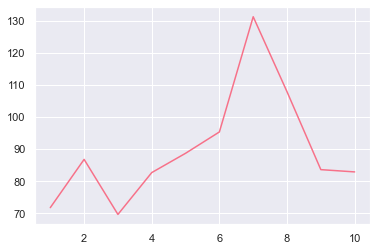

In [34]:
best_lr_idx = [None, None]
best_rmse = 9999
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

rmse_lst = []
k = []

i = 1
for train_index, test_index in kfold.split(X, y):
    lr = LinearRegression()
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lr.fit(X_train, y_train)
    
    y_preds = np.round(lr.predict(X_test), decimals=2)
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    r2 = r2_score(y_test, y_preds)
    
    print("k =", i)
    # The mean squared error
    print('Root mean squared error: %.2f' % rmse)
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f' % r2)
    print()
    
    rmse_lst.append(rmse)
    k.append(i)
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_lr_idx[0] = train_index
        best_lr_idx[1] = test_index
    
    i += 1
    
sns.lineplot(x = k, y = rmse_lst)

In [35]:
lr = LinearRegression()

train_index, test_index = best_lr_idx
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

lr.fit(X_train, y_train)
y_preds = np.round(lr.predict(X_test), decimals=2)

Predicted Price Range:  -22.2 546.89
Actual Price Range:  16.0 799.0


Actual Values  Predicted Values
0            75.0             63.44
1           105.0             72.51
2           115.0             89.91
3           127.0            161.25
4           120.0            148.32
5            71.0            163.10
6           128.0             88.30
7            88.0             66.72
8           125.0            158.46
9            80.0             56.96
10           99.0            164.41
11           88.0            158.89
12          395.0            224.16
13          250.0            167.80
14          304.0            195.25
15          350.0            313.54
16          180.0            144.88
17           83.0             76.85
18          360.0            248.07
19          104.0            104.56

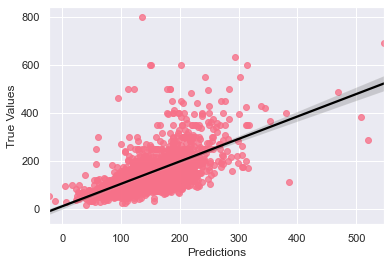

In [36]:
sns.regplot(x = y_preds, y = y_test, fit_reg = True, line_kws={"color": "black"})
plt.xlabel("Predictions")
plt.ylabel("True Values")

print("Predicted Price Range: ", np.min(y_preds), np.max(y_preds))
print("Actual Price Range: ", np.min(y_test), np.max(y_test))

error_diff = pd.DataFrame({'Actual Values': np.array(y_test).flatten(), 'Predicted Values': y_preds.flatten()})
error_diff1 = error_diff.head(20)
error_diff1

<h3>Get Feature Importances</h3><br>
<p>We can fit a LinearRegression model on the regression dataset and retrieve the coef_ property that contains the coefficients found for each input variable.

These coefficients can provide the basis for a crude feature importance score. This assumes that the input variables have the same scale or have been scaled prior to fitting a model.</p>

latitude -71.44473472726258
longitude -62.868876741583954
room_type -30.38384927020493
review_scores_value -12.291814118456466
review_scores_communication -6.767004244790565
number_of_reviews_l30d -5.059316698338607
host_response_time -4.933134253660283
review_scores_accuracy -4.070904405090318
calculated_host_listings_count_private_rooms -2.565160914897952
review_scores_checkin -2.227592613745187
availability_60 -1.822823230618194
beds -0.9221773886435296
calculated_host_listings_count_entire_homes -0.6421569070030034
number_of_reviews_ltm -0.5617796025250011
neighborhood_group -0.22963225995484776
neighborhood -0.229632259936915
host_neighbourhood -0.19924500561604333
host_response_rate -0.18119135807710862
number_of_reviews -0.07540805139050534
host_acceptance_rate -0.0130099876371083
maximum_nights -0.002242720254286889
name -6.950178860645807e-05
has_availability 5.915268275202834e-13
description 9.332517749300623e-05
host_about 0.000511587331832338
host_since 0.001881517615559328

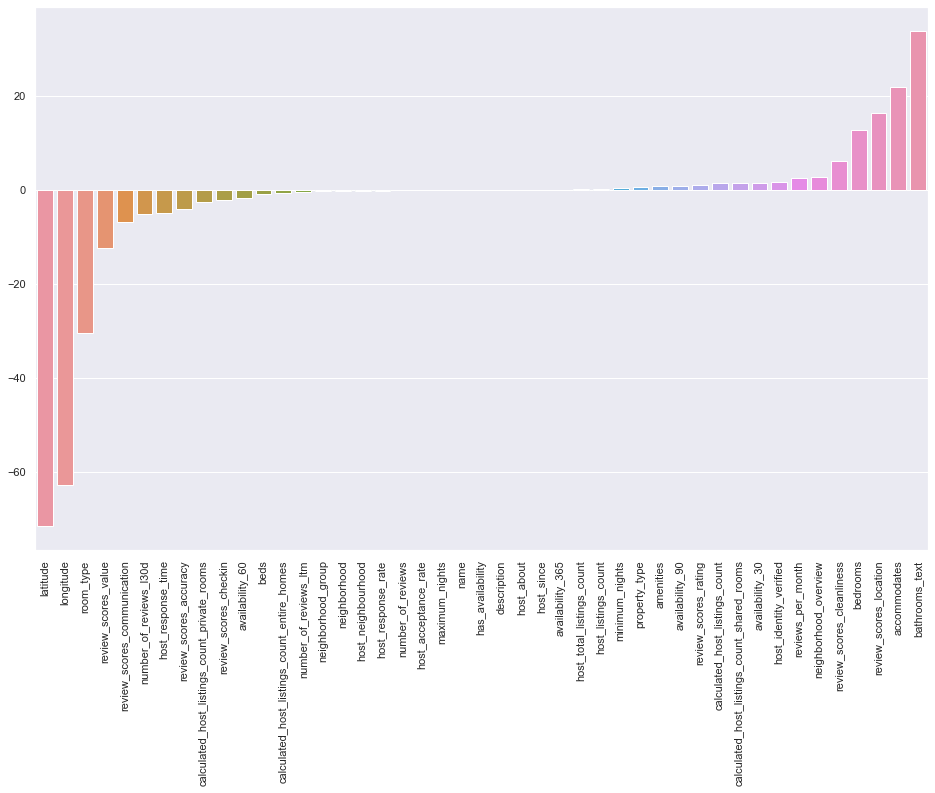

In [37]:
# get importance
importance = lr.coef_
imp_dict = dict()
# summarize feature importance
for i,v in enumerate(importance):
    #print('Feature %0d: %s, Score: %.5f' % (i, X.columns[i], v))
    imp_dict[X.columns[i]] = v
    
sorted_imp = sorted(imp_dict.items(), key=lambda kv: kv[1])
for k, v in sorted_imp:
    print(k, v)
# plot feature importance
fig = plt.gcf()
fig.set_size_inches( 16, 10)
plt.xticks(rotation='vertical')
sns.barplot(x=[k for k, v in sorted_imp], y=[v for k, v in sorted_imp])
plt.show()

<h2>Random Forest Regressor</h2>

In [38]:
listings_cleaned_price = pd.read_csv('listings_cleaned_amsterdam.csv')
listings_cleaned_price = listings_cleaned_price.dropna()

X = listings_cleaned_price.copy()
y = X.pop('price')

k = 1
Mean absolute error: 42.81
Root mean squared error: 66.80
Coefficient of determination: 0.48

k = 2
Mean absolute error: 46.00
Root mean squared error: 82.35
Coefficient of determination: 0.41

k = 3
Mean absolute error: 44.25
Root mean squared error: 79.62
Coefficient of determination: 0.19

k = 4
Mean absolute error: 44.83
Root mean squared error: 79.87
Coefficient of determination: 0.32

k = 5
Mean absolute error: 44.74
Root mean squared error: 85.25
Coefficient of determination: 0.33

k = 6
Mean absolute error: 45.16
Root mean squared error: 89.55
Coefficient of determination: 0.43

k = 7
Mean absolute error: 46.06
Root mean squared error: 126.39
Coefficient of determination: 0.24

k = 8
Mean absolute error: 48.27
Root mean squared error: 104.59
Coefficient of determination: 0.26

k = 9
Mean absolute error: 44.54
Root mean squared error: 80.10
Coefficient of determination: 0.35

k = 10
Mean absolute error: 46.15
Root mean squared error: 77.80
Coefficient of determination: 0.4

<AxesSubplot:>

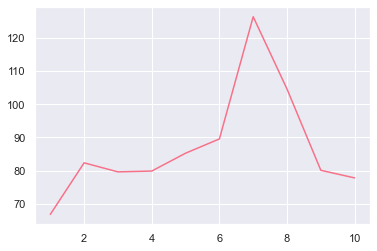

In [39]:
best_regr_idx = [None, None]
best_rmse = 9999
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

rmse_lst = []
k = []

i = 1
for train_index, test_index in kfold.split(X, y):
    regr = RandomForestRegressor(random_state=42)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    regr.fit(X_train, y_train)
    
    y_preds = np.round(regr.predict(X_test), decimals=2)
    mae = mean_absolute_error(y_test, y_preds)
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    r2 = r2_score(y_test, y_preds)
    
    print("k =", i)
    # The mean absolute error
    print('Mean absolute error: %.2f' % mae)
    # The mean squared error
    print('Root mean squared error: %.2f' % rmse)
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f' % r2)
    print()
    
    rmse_lst.append(rmse)
    k.append(i)
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_regr_idx[0] = train_index
        best_regr_idx[1] = test_index
    
    i += 1
    
sns.lineplot(x = k, y = rmse_lst)

In [40]:
regr = RandomForestRegressor(random_state=42)

train_index, test_index = best_regr_idx
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

regr.fit(X_train, y_train)
y_preds = np.round(regr.predict(X_test), decimals=2)

Predicted Price Range:  45.65 709.52
Actual Price Range:  20.0 800.0


Actual Values  Predicted Values
0            59.0            103.20
1           211.0            208.87
2           115.0            305.91
3           100.0             85.93
4           124.0            122.13
5            45.0            125.31
6            65.0             70.79
7           150.0            170.36
8            99.0            155.84
9            97.0            279.96
10          157.0            253.72
11          149.0            129.41
12          116.0            111.76
13          228.0            226.42
14           95.0            139.10
15          169.0            130.39
16           95.0            144.53
17          199.0            144.75
18          150.0            154.04
19          179.0            288.55

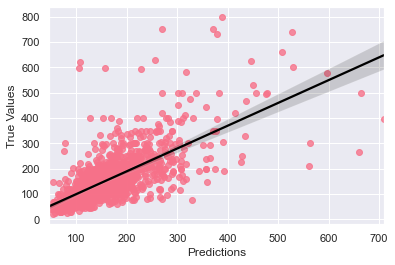

In [41]:
sns.regplot(x = y_preds, y = y_test, fit_reg = True, line_kws={"color": "black"})
plt.xlabel("Predictions")
plt.ylabel("True Values")

print("Predicted Price Range: ", np.min(y_preds), np.max(y_preds))
print("Actual Price Range: ", np.min(y_test), np.max(y_test))

error_diff = pd.DataFrame({'Actual Values': np.array(y_test).flatten(), 'Predicted Values': y_preds.flatten()})
error_diff1 = error_diff.head(20)
error_diff1

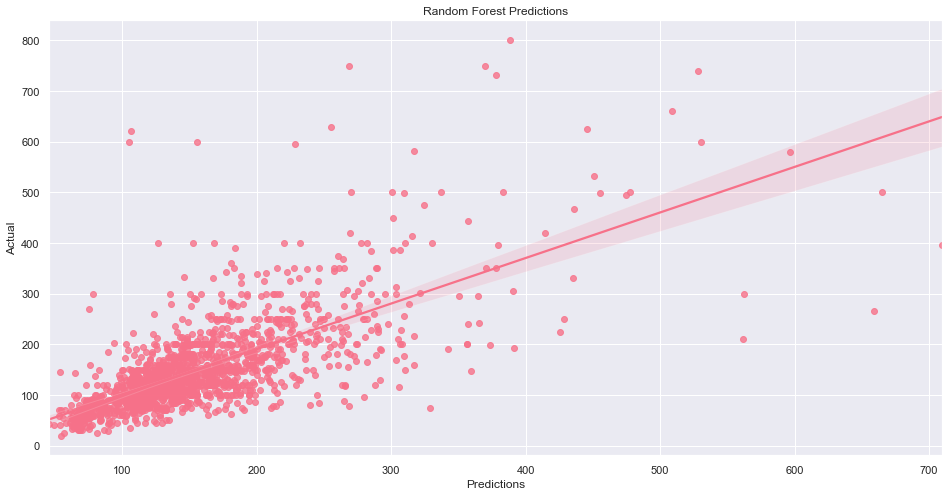

In [42]:
import plotly.graph_objs as go
import plotly.express as px

title=['Pred vs Actual']
fig = go.Figure(data=[
    go.Bar(name='Predicted', x=error_diff1.index, y=error_diff['Predicted Values']),
    go.Bar(name='Actual', x=error_diff1.index, y=error_diff['Actual Values'])
])
fig.update_layout(barmode='group')
fig.show()

plt.figure(figsize=(16,8))
sns.regplot(y_preds,y_test)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title("Random Forest Predictions")
plt.show()

<h3>Get Feature Importances</h3><br>
<p>We can fit a RandomForestRegressor model on the regression dataset and retrieve the feature_importances_ property.
The higher, the more important the feature. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.</p>

Feature 0: name, Score: 0.03831
Feature 1: description, Score: 0.03116
Feature 2: neighborhood_overview, Score: 0.00901
Feature 3: host_since, Score: 0.03444
Feature 4: host_about, Score: 0.01974
Feature 5: host_response_time, Score: 0.00616
Feature 6: host_response_rate, Score: 0.00480
Feature 7: host_acceptance_rate, Score: 0.01622
Feature 8: host_neighbourhood, Score: 0.02913
Feature 9: host_listings_count, Score: 0.01192
Feature 10: host_total_listings_count, Score: 0.01251
Feature 11: host_identity_verified, Score: 0.00377
Feature 12: neighborhood, Score: 0.01291
Feature 13: neighborhood_group, Score: 0.01260
Feature 14: latitude, Score: 0.03584
Feature 15: longitude, Score: 0.04255
Feature 16: property_type, Score: 0.02057
Feature 17: room_type, Score: 0.02891
Feature 18: accommodates, Score: 0.18109
Feature 19: bathrooms_text, Score: 0.04513
Feature 20: bedrooms, Score: 0.01897
Feature 21: beds, Score: 0.01709
Feature 22: amenities, Score: 0.03632
Feature 23: minimum_nights, Sco

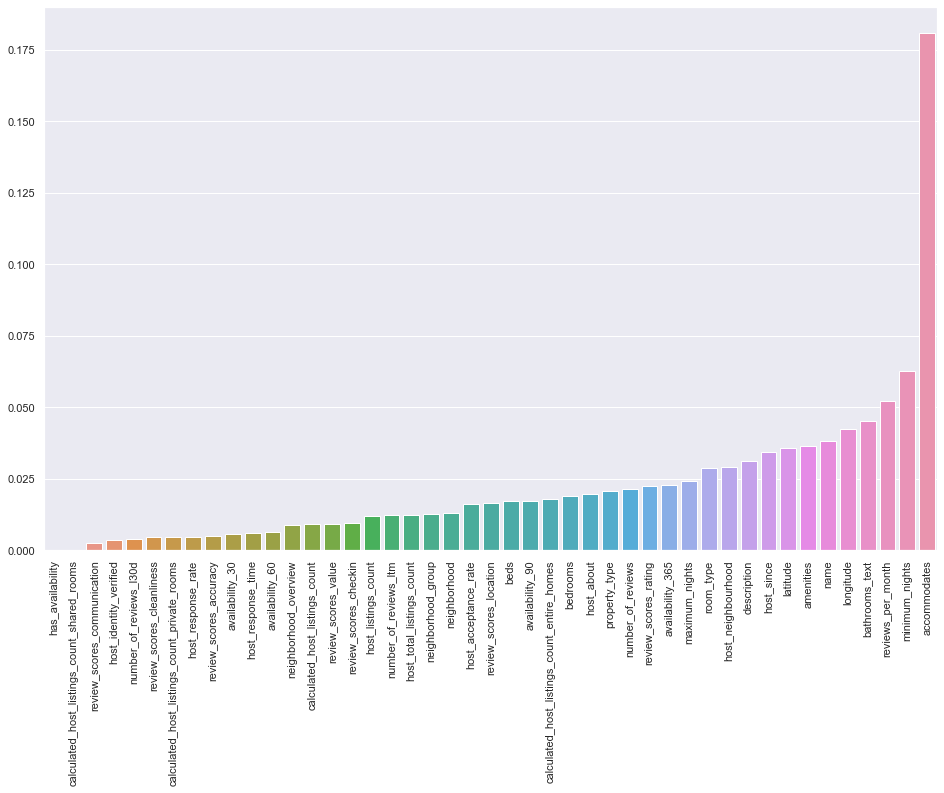

In [43]:
# get importance
importance = regr.feature_importances_
imp_dict = dict()
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature %0d: %s, Score: %.5f' % (i, X.columns[i], v))
    imp_dict[X.columns[i]] = v
    
sorted_imp = sorted(imp_dict.items(), key=lambda kv: kv[1])
# plot feature importance
fig = plt.gcf()
fig.set_size_inches(16, 10)
plt.xticks(rotation='vertical')
sns.barplot(x=[k for k, v in sorted_imp], y=[v for k, v in sorted_imp])
plt.show()

<h2>Neural Network - Price Only</h2>

In [44]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [46]:
listings_cleaned_price = pd.read_csv('listings_cleaned_amsterdam.csv')
listings_cleaned_price = listings_cleaned_price.dropna()

listings_cleaned_price

name  description  neighborhood_overview  host_since  host_about  \
0      13495        11233                      1           0        7528   
1      15916          275                      4          10          87   
2      10121         7698                      0           7        7957   
3      13892        12531                      0          19        6452   
4       5029          609                      1          25        2095   
...      ...          ...                    ...         ...         ...   
18701   7572        13700                      0        3225        8748   
18717  16774         4883                      0        3230        1014   
18722  16773         4882                      0        3230        1014   
18726  11209         1453                      2        3229        8748   
18735   9653        12838                      0        3229        8748   

       host_response_time  host_response_rate  host_acceptance_rate  \
0                       1                  49                     2   
1                       1                  49                     2   
2                       3                   2                    32   
3                       1                  49                     2   
4                       4                   2                    93   
...                   ...                 ...                   ...   
18701                   4                   2                     2   
18717                   4                  42                     2   
18722                   4                  42                     2   
18726                   4                   2                     2   
18735                   4                   2                    95   

       host_neighbourhood  host_listings_count  ...  \
0                      30                  1.0  ...   
1                      27                  2.0  ...   
2                      27                  2.0  ...   
3                      75                  1.0  ...   
4                       0                  2.0  ...   
...                   ...                  ...  ...   
18701                  79                  2.0  ...   
18717                  79                  0.0  ...   
18722                  79                  0.0  ...   
18726                  79                  0.0  ...   
18735                  79                  0.0  ...   

       review_scores_cleanliness  review_scores_checkin  \
0                           10.0                   10.0   
1                           10.0                   10.0   
2                           10.0                   10.0   
3                           10.0                   10.0   
4                           10.0                   10.0   
...                          ...                    ...   
18701                       10.0                   10.0   
18717                       10.0                   10.0   
18722                       10.0                   10.0   
18726                       10.0                   10.0   
18735                       10.0                   10.0   

       review_scores_communication  review_scores_location  \
0                             10.0                     9.0   
1                             10.0                    10.0   
2                             10.0                    10.0   
3                             10.0                    10.0   
4                             10.0                    10.0   
...                            ...                     ...   
18701                         10.0                     8.0   
18717                         10.0                    10.0   
18722                         10.0                    10.0   
18726                         10.0                    10.0   
18735                         10.0                    10.0   

       review_scores_value  calculated_host_listings_count  \
0                     10.0                               1   
1  

In [47]:
# scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
# X = scaler.fit_transform(listings_cleaned_price.copy())

# multiplied_by = scaler.scale_[13]
# added = scaler.min_[13]

# X = pd.DataFrame(X, columns=listings_cleaned_price.columns.values)
X = listings_cleaned_price.copy()
y = X.pop('price')

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
nn = Sequential()

# The Input Layer :
nn.add(Dense(45, input_dim = 45, activation='relu'))

# The Hidden Layers :
nn.add(Dense(90, activation='relu'))
nn.add(Dense(45, activation='relu'))

# The Output Layer :
nn.add(Dense(1, activation='linear'))

# Compile the network :
nn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 45)                2070      
_________________________________________________________________
dense_1 (Dense)              (None, 90)                4140      
_________________________________________________________________
dense_2 (Dense)              (None, 45)                4095      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 46        
Total params: 10,351
Trainable params: 10,351
Non-trainable params: 0
_________________________________________________________________


In [50]:
nn.fit(X_train, y_train, epochs=100, batch_size=32, shuffle=True)

Epoch 1/100
382/382 [==============================] - 0s 591us/step - loss: 20234.8711 - mean_squared_error: 20234.8711
Epoch 2/100
382/382 [==============================] - 0s 521us/step - loss: 14088.9756 - mean_squared_error: 14088.9756
Epoch 3/100
382/382 [==============================] - 0s 582us/step - loss: 13192.2490 - mean_squared_error: 13192.2490
Epoch 4/100
382/382 [==============================] - 0s 566us/step - loss: 12994.1309 - mean_squared_error: 12994.1309
Epoch 5/100
382/382 [==============================] - 0s 553us/step - loss: 12848.2168 - mean_squared_error: 12848.2168
Epoch 6/100
382/382 [==============================] - 0s 526us/step - loss: 12276.1992 - mean_squared_error: 12276.1992
Epoch 7/100
382/382 [==============================] - 0s 498us/step - loss: 12314.4219 - mean_squared_error: 12314.4219
Epoch 8/100
382/382 [==============================] - 0s 505us/step - loss: 11960.2373 - mean_squared_error: 11960.2373
Epoch 9/100
382/382 [===========

382/382 [==============================] - 0s 585us/step - loss: 8620.6123 - mean_squared_error: 8620.6123
Epoch 69/100
382/382 [==============================] - 0s 540us/step - loss: 8889.8662 - mean_squared_error: 8889.8662
Epoch 70/100
382/382 [==============================] - 0s 597us/step - loss: 8880.4434 - mean_squared_error: 8880.4434
Epoch 71/100
382/382 [==============================] - 0s 543us/step - loss: 8869.5146 - mean_squared_error: 8869.5146
Epoch 72/100
382/382 [==============================] - 0s 559us/step - loss: 9146.8145 - mean_squared_error: 9146.8145
Epoch 73/100
382/382 [==============================] - 0s 566us/step - loss: 8994.6162 - mean_squared_error: 8994.6162
Epoch 74/100
382/382 [==============================] - 0s 585us/step - loss: 8436.8223 - mean_squared_error: 8436.8223
Epoch 75/100
382/382 [==============================] - 0s 549us/step - loss: 8547.0713 - mean_squared_error: 8547.0713
Epoch 76/100
382/382 [==============================]

In [51]:
y_preds = np.round(nn.predict(X_test), decimals=2)

# y_preds -= added
# y_preds /= multiplied_by

# y_test -= added
# y_test /= multiplied_by

Predicted Price Range:  9.52 573.52
Actual Price Range:  20.0 1150.0


Actual Values  Predicted Values
0            63.0         89.680000
1            59.0        115.459999
2           110.0        121.959999
3            75.0        100.720001
4            90.0        133.070007
5           150.0        130.210007
6            90.0        143.259995
7           270.0        195.509995
8            75.0        164.520004
9            76.0        125.580002
10          100.0        154.539993
11          200.0        149.429993
12          500.0        243.309998
13          180.0        135.750000
14          125.0        164.729996
15           88.0         84.070000
16           45.0        128.940002
17          140.0        155.800003
18          163.0        152.479996
19          145.0        188.639999

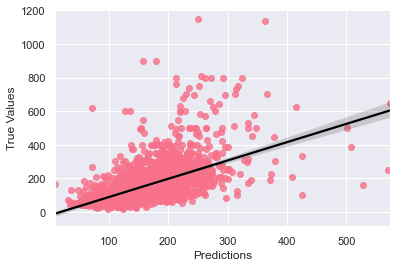

In [52]:
sns.regplot(x = y_preds, y = y_test, fit_reg = True, line_kws={"color": "black"})
plt.xlabel("Predictions")
plt.ylabel("True Values")

print("Predicted Price Range: ", np.min(y_preds), np.max(y_preds))
print("Actual Price Range: ", np.min(y_test), np.max(y_test))

error_diff = pd.DataFrame({'Actual Values': np.array(y_test).flatten(), 'Predicted Values': y_preds.flatten()})
error_diff1 = error_diff.head(20)
error_diff1

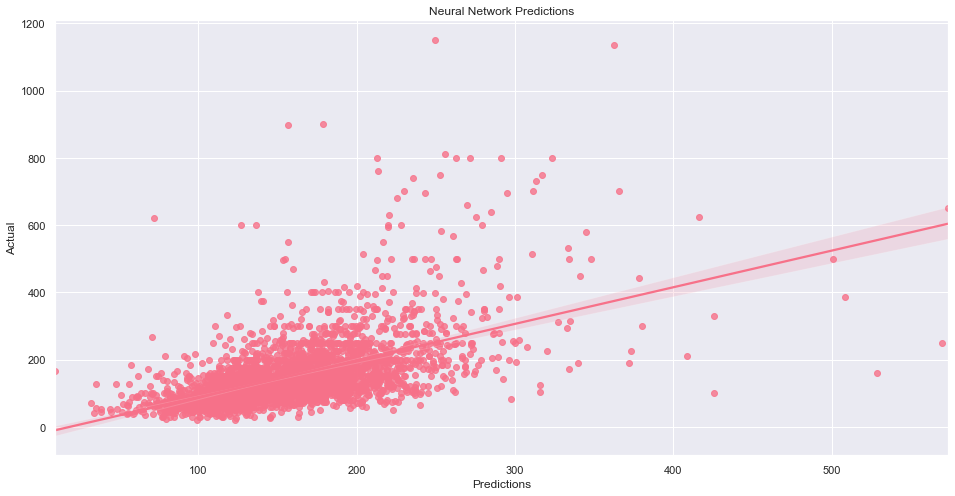

In [53]:
import plotly.graph_objs as go
import plotly.express as px

title=['Pred vs Actual']
fig = go.Figure(data=[
    go.Bar(name='Predicted', x=error_diff1.index, y=error_diff['Predicted Values']),
    go.Bar(name='Actual', x=error_diff1.index, y=error_diff['Actual Values'])
])
fig.update_layout(barmode='group')
fig.show()

plt.figure(figsize=(16,8))
sns.regplot(y_preds,y_test)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title("Neural Network Predictions")
plt.show()

In [54]:
mae = mean_absolute_error(y_test, y_preds)
rmse = np.sqrt(mean_squared_error(y_test, y_preds))
r2 = r2_score(y_test, y_preds)

print("Neural Network")
# The mean absolute error
print('Mean absolute error: %.2f' % mae)
# The mean squared error
print('Root mean squared error: %.2f' % rmse)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2)
print()

Neural Network
Mean absolute error: 53.56
Root mean squared error: 83.88
Coefficient of determination: 0.30



<h2>Neural Network - Ratings</h2>

In [55]:
listings_cleaned_price = pd.read_csv('listings_cleaned_amsterdam.csv')
listings_cleaned_price = listings_cleaned_price.dropna()
listings_cleaned_price = listings_cleaned_price.drop(listings_cleaned_price.index[listings_cleaned_price['review_scores_rating'] <= 40])

listings_cleaned_price

name  description  neighborhood_overview  host_since  host_about  \
0      13495        11233                      1           0        7528   
1      15916          275                      4          10          87   
2      10121         7698                      0           7        7957   
3      13892        12531                      0          19        6452   
4       5029          609                      1          25        2095   
...      ...          ...                    ...         ...         ...   
18701   7572        13700                      0        3225        8748   
18717  16774         4883                      0        3230        1014   
18722  16773         4882                      0        3230        1014   
18726  11209         1453                      2        3229        8748   
18735   9653        12838                      0        3229        8748   

       host_response_time  host_response_rate  host_acceptance_rate  \
0                       1                  49                     2   
1                       1                  49                     2   
2                       3                   2                    32   
3                       1                  49                     2   
4                       4                   2                    93   
...                   ...                 ...                   ...   
18701                   4                   2                     2   
18717                   4                  42                     2   
18722                   4                  42                     2   
18726                   4                   2                     2   
18735                   4                   2                    95   

       host_neighbourhood  host_listings_count  ...  \
0                      30                  1.0  ...   
1                      27                  2.0  ...   
2                      27                  2.0  ...   
3                      75                  1.0  ...   
4                       0                  2.0  ...   
...                   ...                  ...  ...   
18701                  79                  2.0  ...   
18717                  79                  0.0  ...   
18722                  79                  0.0  ...   
18726                  79                  0.0  ...   
18735                  79                  0.0  ...   

       review_scores_cleanliness  review_scores_checkin  \
0                           10.0                   10.0   
1                           10.0                   10.0   
2                           10.0                   10.0   
3                           10.0                   10.0   
4                           10.0                   10.0   
...                          ...                    ...   
18701                       10.0                   10.0   
18717                       10.0                   10.0   
18722                       10.0                   10.0   
18726                       10.0                   10.0   
18735                       10.0                   10.0   

       review_scores_communication  review_scores_location  \
0                             10.0                     9.0   
1                             10.0                    10.0   
2                             10.0                    10.0   
3                             10.0                    10.0   
4                             10.0                    10.0   
...                            ...                     ...   
18701                         10.0                     8.0   
18717                         10.0                    10.0   
18722                         10.0                    10.0   
18726                         10.0                    10.0   
18735                         10.0                    10.0   

       review_scores_value  calculated_host_listings_count  \
0                     10.0                               1   
1  

In [56]:
X = listings_cleaned_price.copy()
y = X.pop('review_scores_rating')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
nn = Sequential()

# The Input Layer :
nn.add(Dense(45, input_dim = 45, activation='relu'))

# The Hidden Layers :
nn.add(Dense(90, activation='relu'))
nn.add(Dense(45, activation='relu'))

# The Output Layer :
nn.add(Dense(1, activation='linear'))

# Compile the network :
nn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 45)                2070      
_________________________________________________________________
dense_5 (Dense)              (None, 90)                4140      
_________________________________________________________________
dense_6 (Dense)              (None, 45)                4095      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 46        
Total params: 10,351
Trainable params: 10,351
Non-trainable params: 0
_________________________________________________________________


In [58]:
nn.fit(X_train, y_train, epochs=100, batch_size=32, shuffle=True)
y_preds = np.round(nn.predict(X_test), decimals=2)

Epoch 1/100
382/382 [==============================] - 0s 583us/step - loss: 11512.4521 - mean_squared_error: 11512.4521
Epoch 2/100
382/382 [==============================] - 0s 529us/step - loss: 565.9706 - mean_squared_error: 565.9706
Epoch 3/100
382/382 [==============================] - 0s 619us/step - loss: 449.9481 - mean_squared_error: 449.9481
Epoch 4/100
382/382 [==============================] - 0s 530us/step - loss: 391.1366 - mean_squared_error: 391.1366
Epoch 5/100
382/382 [==============================] - 0s 531us/step - loss: 366.4389 - mean_squared_error: 366.4389
Epoch 6/100
382/382 [==============================] - 0s 619us/step - loss: 395.1199 - mean_squared_error: 395.1199
Epoch 7/100
382/382 [==============================] - 0s 599us/step - loss: 453.7219 - mean_squared_error: 453.7219
Epoch 8/100
382/382 [==============================] - 0s 512us/step - loss: 287.5964 - mean_squared_error: 287.5964
Epoch 9/100
382/382 [==============================] - 0s 52

382/382 [==============================] - 0s 520us/step - loss: 21.2317 - mean_squared_error: 21.2317
Epoch 72/100
382/382 [==============================] - 0s 522us/step - loss: 23.1810 - mean_squared_error: 23.1810
Epoch 73/100
382/382 [==============================] - 0s 549us/step - loss: 23.2454 - mean_squared_error: 23.2454
Epoch 74/100
382/382 [==============================] - 0s 485us/step - loss: 22.8943 - mean_squared_error: 22.8943
Epoch 75/100
382/382 [==============================] - 0s 527us/step - loss: 22.8279 - mean_squared_error: 22.8279
Epoch 76/100
382/382 [==============================] - 0s 497us/step - loss: 20.7191 - mean_squared_error: 20.7191
Epoch 77/100
382/382 [==============================] - 0s 531us/step - loss: 21.7042 - mean_squared_error: 21.7042
Epoch 78/100
382/382 [==============================] - 0s 521us/step - loss: 19.8474 - mean_squared_error: 19.8474
Epoch 79/100
382/382 [==============================] - 0s 523us/step - loss: 23.0796

Predicted Rating Range:  47.5 102.14
Actual Rating Range:  60.0 100.0


Actual Values  Predicted Values
0            92.0         93.089996
1            98.0         93.430000
2            98.0         92.419998
3            94.0         85.739998
4           100.0         95.580002
5           100.0         95.809998
6            93.0         98.529999
7            99.0         97.589996
8            86.0         85.849998
9           100.0         92.699997
10          100.0         99.940002
11           80.0         91.239998
12           97.0         99.639999
13          100.0         93.900002
14           98.0         95.430000
15           98.0         96.580002
16           97.0         96.160004
17          100.0         94.940002
18           97.0         95.709999
19           87.0         92.580002

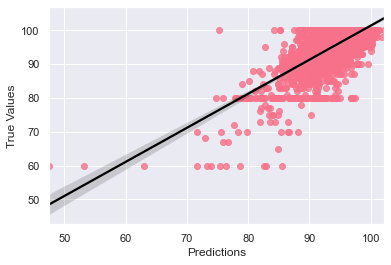

In [60]:
sns.regplot(x = y_preds, y = y_test, fit_reg = True, line_kws={"color": "black"})
plt.xlabel("Predictions")
plt.ylabel("True Values")

print("Predicted Rating Range: ", np.min(y_preds), np.max(y_preds))
print("Actual Rating Range: ", np.min(y_test), np.max(y_test))

error_diff = pd.DataFrame({'Actual Values': np.array(y_test).flatten(), 'Predicted Values': y_preds.flatten()})
error_diff1 = error_diff.head(20)
error_diff1

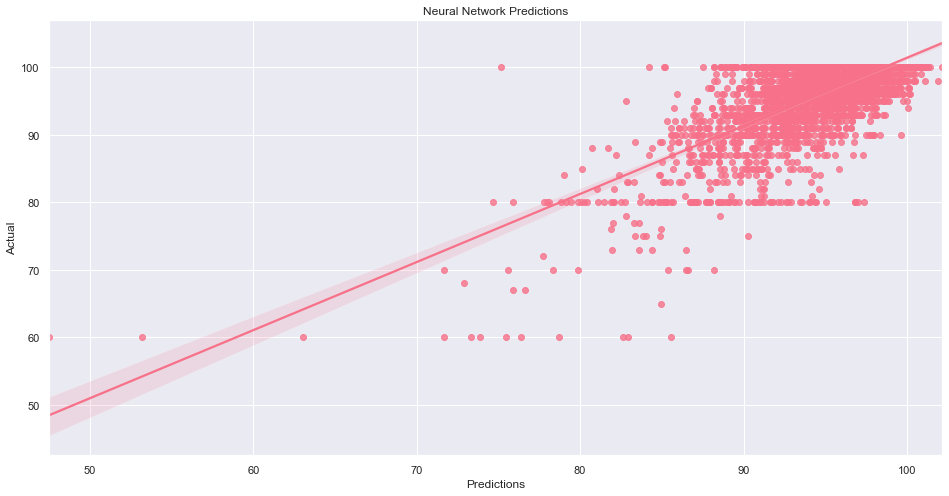

In [61]:
title=['Pred vs Actual']
fig = go.Figure(data=[
    go.Bar(name='Predicted', x=error_diff1.index, y=error_diff['Predicted Values']),
    go.Bar(name='Actual', x=error_diff1.index, y=error_diff['Actual Values'])
])
fig.update_layout(barmode='group')
fig.show()

plt.figure(figsize=(16,8))
sns.regplot(y_preds,y_test)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title("Neural Network Predictions")
plt.show()

In [62]:
mae = mean_absolute_error(y_test, y_preds)
rmse = np.sqrt(mean_squared_error(y_test, y_preds))
r2 = r2_score(y_test, y_preds)

print("Neural Network")
# The mean absolute error
print('Mean absolute error: %.2f' % mae)
# The mean squared error
print('Root mean squared error: %.2f' % rmse)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2)
print()

Neural Network
Mean absolute error: 3.37
Root mean squared error: 4.37
Coefficient of determination: 0.43

